Author: Geoff Boeing
<br />
Web: http://geoffboeing.com
<br />
Date: 2014-08-31
<br />
Updated: 2015-08-27
<br />
Description: This notebook uses shapely's implementation of the douglas-peucker algorithm to reduce the size of a spatial data set. The full data set consists of 1,759 lat-long coordinate points. More info: http://geoffboeing.com/2014/08/visualizing-summer-travels/

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from shapely.geometry import LineString
from time import time

In [2]:
# load the point data
df = pd.read_csv('data/summer-travel-gps-full.csv')
coordinates = df.as_matrix(columns=['lat', 'lon'])

In [3]:
# create a shapely line from the point data
line = LineString(coordinates)

# all points in the simplified object will be within the tolerance distance of the original geometry
tolerance = 0.015

# if preserve topology is set to False the much quicker Douglas-Peucker algorithm is used
# we don't need to preserve topology bc we just need a set of points, not the relationship between them
simplified_line = line.simplify(tolerance, preserve_topology=False)

print line.length, 'line length'
print simplified_line.length, 'simplified line length'
print len(line.coords), 'coordinate pairs in full data set'
print len(simplified_line.coords), 'coordinate pairs in simplified data set'
print round(((1 - float(len(simplified_line.coords)) / float(len(line.coords))) * 100), 1), 'percent compressed'

146.334538996 line length
143.926116262 simplified line length
1759 coordinate pairs in full data set
178 coordinate pairs in simplified data set
89.9 percent compressed


In [4]:
# save the simplified set of coordinates as a new dataframe
lon = pd.Series(pd.Series(simplified_line.coords.xy)[1])
lat = pd.Series(pd.Series(simplified_line.coords.xy)[0])
si = pd.DataFrame({'lon':lon, 'lat':lat})
si.tail()

,lat,lon
173,41.044556,28.983285
174,41.008992,28.968268
175,41.043487,28.985488
176,40.977637,28.823879
177,48.357110,11.791346


In [5]:
start_time = time()

# df_index will contain the index of the matching row from the original full data set
si['df_index'] = None

# for each coordinate pair in the simplified set
for si_i, si_row in si.iterrows():
    
    si_coords = (si_row['lat'], si_row['lon'])
    # for each coordinate pair in the original full data set
    for df_i, df_row in df.iterrows():
        
        # compare tuples of coordinates, if the points match, save this row's index as the matching one
        if si_coords == (df_row['lat'], df_row['lon']):
            si.loc[si_i, 'df_index'] = df_i
            break
            
print 'process took %s seconds' % round(time() - start_time, 2)

process took 6.04 seconds


In [6]:
si.tail()

,lat,lon,df_index
173,41.044556,28.983285,1730
174,41.008992,28.968268,1739
175,41.043487,28.985488,1745
176,40.977637,28.823879,1751
177,48.357110,11.791346,1758


In [7]:
# select the rows from the original full data set whose indices appear in the df_index
# column of the simplified data set
rs = df.ix[si['df_index'].dropna()]

#rs.to_csv('data/summer-travel-gps-simplified.csv', index=False)
rs.tail()

,lat,lon,date,city,country
1730,41.044556,28.983285,07/08/2014 16:44,Istanbul,Turkey
1739,41.008992,28.968268,07/08/2014 20:03,Istanbul,Turkey
1745,41.043487,28.985488,07/08/2014 22:18,Istanbul,Turkey
1751,40.977637,28.823879,07/09/2014 09:03,Istanbul,Turkey
1758,48.357110,11.791346,07/09/2014 13:20,Munich,Germany


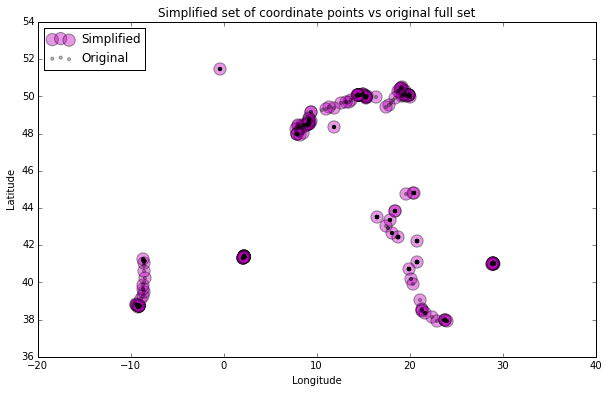

In [8]:
# plot the final simplified set of coordinate points vs the original full set
plt.figure(figsize=(10, 6), dpi=100)
rs_scatter = plt.scatter(rs['lon'], rs['lat'], c='m', alpha=.4, s=150)
df_scatter = plt.scatter(df['lon'], df['lat'], c='k', alpha=.3, s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Simplified set of coordinate points vs original full set')
plt.legend((rs_scatter, df_scatter), ('Simplified', 'Original'), loc='upper left')
plt.show()